Final Task: Aim to classify the tweets.

In [3]:
import numpy as np
import pandas as pd

In [4]:
!gdown --id 1RARLRRVmkaoHQV05pfGIvyBH6XRjcSr9

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RARLRRVmkaoHQV05pfGIvyBH6XRjcSr9
To: /content/tweets.csv
100% 8.70M/8.70M [00:00<00:00, 223MB/s]


In [5]:
data= pd.read_csv('tweets.csv')
data

,Unnamed: 0,tweet,target
0,0,ndtv anchor let go over to aap live press conf...,0
1,1,sambit patra attacks rahul gandhi over his cow...,0
2,2,crediting the bjp with taking development to s...,1
3,3,ktrbrs do do false allegations on iasassociati...,0
4,4,gujarat assembly yet to get rs cr as gst compe...,1
...,...,...,...
49472,25683,1ddrive modispeakstonews18 loksabhaelections20...,1
49473,25684,i am seriously worried about future of indian ...,1
49474,25685,if narendramodi is so bad then why does incind...,0
49475,25686,on this 23rd march pakistan day i urge all ind...,0


Government tweets are labeled with 1 while opposition tweets are labeled with 0. I have already done the data pre-processing part to make it easy for you all.
Go-ahead and do **encode -> spliting -> classification using model**.
You have already done this task in last two assignments. **Best of Luck!**

Optional: You can also try clustring algorithem, this would give you a better result.

In [35]:
tweets=data['tweet']
y=data['target']
print("length of data is "+str(len(tweets)))


length of data is 49477


In [9]:
%%capture
!pip3 install seaborn

In [10]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


# SIMILARITY PLOT OF FIRST 50 TWEETS

In [27]:
t = tweets[:50]

In [28]:

logging.set_verbosity(logging.ERROR)

message_embeddings = embed(t)



In [29]:
print(message_embeddings.shape)
print(type(message_embeddings))

(50, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [30]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels.index,
      yticklabels=labels.index,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels.index, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

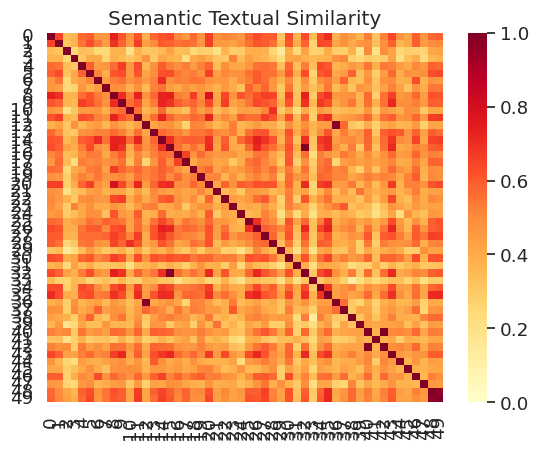

In [31]:
run_and_plot(t)

# TRAINING MODEL

In [32]:
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(tweets)

In [33]:
print(message_embeddings.shape)
print(type(message_embeddings))

(49477, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [40]:
from sklearn.model_selection import train_test_split


X = np.array(message_embeddings )
y=np.array(y) # Shape: (49477, 512)

X_train, X_t,y_train,y_t = train_test_split(X,y, test_size=0.4, random_state=42)

print("Training set shape:", X_train.shape)
X_test, X_cv,y_test,y_cv = train_test_split(X_t,y_t, test_size=0.5, random_state=42)
print("Test set shape:", X_test.shape)
print("validation set shape:", X_cv.shape)

Training set shape: (29686, 512)
Test set shape: (9895, 512)
validation set shape: (9896, 512)


In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(2),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [42]:
from keras.backend import sparse_categorical_crossentropy
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model=Sequential([
      tf.keras.layers.Dense(512),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(2),
    ])

from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
history=model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_cv,y_cv))

Epoch 1/50
928/928 [==============================] - 9s 9ms/step - loss: 0.6438 - val_loss: 0.5974
Epoch 2/50
928/928 [==============================] - 8s 9ms/step - loss: 0.5562 - val_loss: 0.5365
Epoch 3/50
928/928 [==============================] - 9s 10ms/step - loss: 0.5123 - val_loss: 0.5147
Epoch 4/50
928/928 [==============================] - 9s 10ms/step - loss: 0.4959 - val_loss: 0.5071
Epoch 5/50
928/928 [==============================] - 9s 10ms/step - loss: 0.4891 - val_loss: 0.5038
Epoch 6/50
928/928 [==============================] - 6s 7ms/step - loss: 0.4856 - val_loss: 0.5021
Epoch 7/50
928/928 [==============================] - 8s 8ms/step - loss: 0.4836 - val_loss: 0.5002
Epoch 8/50
928/928 [==============================] - 6s 7ms/step - loss: 0.4819 - val_loss: 0.5008
Epoch 9/50
928/928 [==============================] - 7s 8ms/step - loss: 0.4810 - val_loss: 0.4985
Epoch 10/50
928/928 [==============================] - 7s 7ms/step - loss: 0.4801 - val_loss: 0.4

In [43]:
hist=pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,loss,val_loss,epoch
45,0.471364,0.494616,45
46,0.471424,0.495633,46
47,0.471215,0.494451,47
48,0.470920,0.494422,48
49,0.471113,0.494344,49


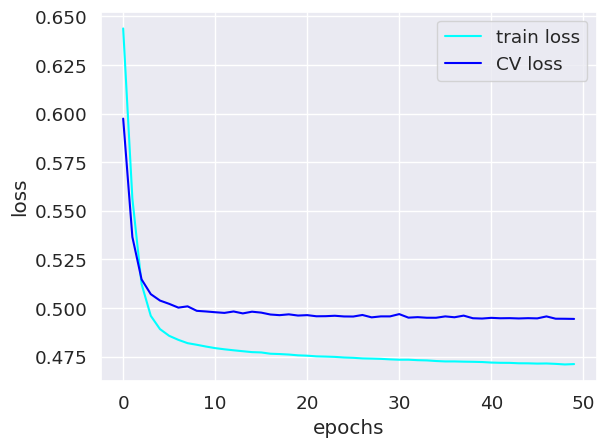

In [44]:
import matplotlib.pyplot as plt

plt.plot(hist['epoch'],hist['loss'],color='cyan',label='train loss')
plt.plot(hist['epoch'],hist['val_loss'],color='blue',label='CV loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

models = {}
models['LogisticRegression'] = LogisticRegression(C=5, max_iter=1000)
models['RidgeClassifier'] = RidgeClassifier(alpha=1.0, solver="sparse_cg")
models['KNeighborsClassifier'] = KNeighborsClassifier(n_neighbors=100)


for model_name, model in models.items():
    print(f"Fitting {model_name}...")
    model.fit(X_train, y_train)


    y_pred_cv = model.predict(X_cv)
    y_pred_test = model.predict(X_test)

    accuracy_cv = metrics.accuracy_score(y_cv, y_pred_cv)
    accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
    print(f"Training accuracy for validation set: {accuracy_cv}")
    print(f"Training accuracy for test set: {accuracy_test}")
    print()

Fitting LogisticRegression...
Training accuracy for validation set: 0.7621261115602264
Training accuracy for test set: 0.7748357756442648

Fitting RidgeClassifier...
Training accuracy for validation set: 0.7601050929668552
Training accuracy for test set: 0.7732187973724103

Fitting KNeighborsClassifier...
Training accuracy for validation set: 0.7370654810024252
Training accuracy for test set: 0.7539161192521475

